In [1]:
import pandas as pd

df = pd.read_csv("data/german.data-numeric", sep=r"\s+", header=None, engine="python")

n_cols = df.shape[1]
if n_cols < 2:
    raise ValueError(f"Unexpected column count: {n_cols}")

if n_cols == 21:
    # Classic: 20 features + target
    cols = [
        "checking_status", "duration_months", "credit_history", "purpose", "credit_amount",
        "savings_status", "employment_since", "installment_rate_pct", "personal_status_sex", "other_debtors",
        "residence_since", "property_magnitude", "age_years", "other_installment_plans", "housing",
        "number_existing_credits", "job", "people_liable_maintenance", "telephone", "foreign_worker",
        "target"
    ]
elif n_cols == 25:
    # UCI numeric (Statlog) variant: 24 features + target
    # The extra 4 are engineered indicator variables in that numeric release.
    cols = [
        "checking_status", "duration_months", "credit_history", "purpose", "credit_amount",
        "savings_status", "employment_since", "installment_rate_pct", "personal_status_sex", "other_debtors",
        "residence_since", "property_magnitude", "age_years", "other_installment_plans", "housing",
        "number_existing_credits", "job", "people_liable_maintenance", "telephone", "foreign_worker",
        "extra_indicator_1", "extra_indicator_2", "extra_indicator_3", "extra_indicator_4",
        "target"
    ]
# else:
#     # Fallback: name generically
#     cols = [f"feature_{i}" for i in range(1, n_cols)] + ["target"]


df.columns = cols

# Map target: 1 = good, 2 = bad  -> 0 = good, 1 = bad
df["target"] = df["target"].map({1: 0, 2: 1})

print("Shape:", df.shape)
print("First rows:")
display(df.head())

print("\nClass balance (0=good, 1=bad):")
print(df["target"].value_counts(normalize=True).round(3))
print("\nMissing values per column (top 10 shown):")
print(df.isna().sum().sort_values(ascending=False).head(10))

Shape: (1000, 25)
First rows:


,checking_status,duration_months,credit_history,purpose,credit_amount,savings_status,employment_since,installment_rate_pct,personal_status_sex,other_debtors,...,number_existing_credits,job,people_liable_maintenance,telephone,foreign_worker,extra_indicator_1,extra_indicator_2,extra_indicator_3,extra_indicator_4,target
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,0
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,1
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,0
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,0
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,1



Class balance (0=good, 1=bad):
target
0    0.7
1    0.3
Name: proportion, dtype: float64

Missing values per column (top 10 shown):
checking_status              0
other_installment_plans      0
extra_indicator_4            0
extra_indicator_3            0
extra_indicator_2            0
extra_indicator_1            0
foreign_worker               0
telephone                    0
people_liable_maintenance    0
job                          0
dtype: int64


In [2]:
for c in [col for col in df.columns if col.startswith("extra_indicator_")]:
    print(c)
    print(df[c].value_counts().sort_index(), "\n")

extra_indicator_1
extra_indicator_1
0    287
1    713
Name: count, dtype: int64 

extra_indicator_2
extra_indicator_2
0    978
1     22
Name: count, dtype: int64 

extra_indicator_3
extra_indicator_3
0    800
1    200
Name: count, dtype: int64 

extra_indicator_4
extra_indicator_4
0    370
1    630
Name: count, dtype: int64 



In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [5]:
print("Shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())
print("\nTarget distribution:\n", df['target'].value_counts(normalize=True))

Shape: (1000, 25)

Data types:
 checking_status              int64
duration_months              int64
credit_history               int64
purpose                      int64
credit_amount                int64
savings_status               int64
employment_since             int64
installment_rate_pct         int64
personal_status_sex          int64
other_debtors                int64
residence_since              int64
property_magnitude           int64
age_years                    int64
other_installment_plans      int64
housing                      int64
number_existing_credits      int64
job                          int64
people_liable_maintenance    int64
telephone                    int64
foreign_worker               int64
extra_indicator_1            int64
extra_indicator_2            int64
extra_indicator_3            int64
extra_indicator_4            int64
target                       int64
dtype: object

Missing values:
 checking_status              0
duration_months              0

In [6]:
import numpy as np

numeric_cols = ["duration_months", "credit_amount", "age_years"]

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outliers} outliers (bounds: {lower:.1f}, {upper:.1f})")

duration_months: 70 outliers (bounds: -6.0, 42.0)
credit_amount: 0 outliers (bounds: -2.0, 6.0)
age_years: 155 outliers (bounds: 1.0, 1.0)


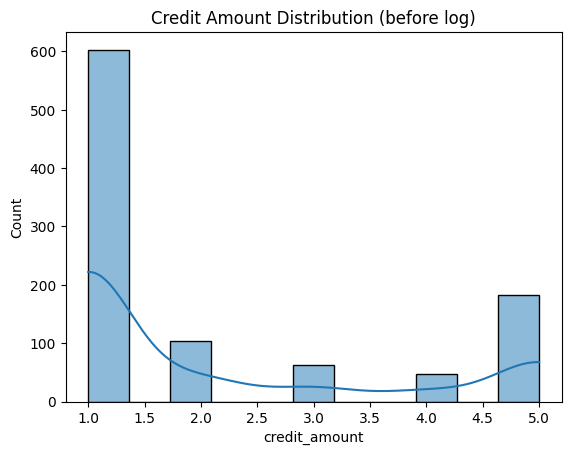

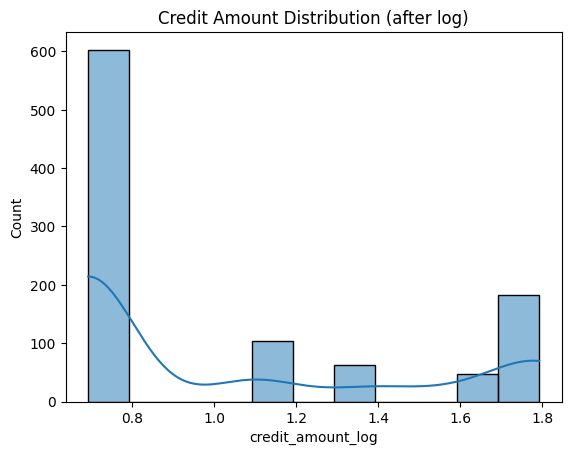

In [7]:
sns.histplot(df["credit_amount"], kde=True)
plt.title("Credit Amount Distribution (before log)")
plt.show()

# Apply log-transform
df["credit_amount_log"] = np.log1p(df["credit_amount"])
sns.histplot(df["credit_amount_log"], kde=True)
plt.title("Credit Amount Distribution (after log)")
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[["duration_scaled", "credit_amount_scaled", "age_scaled"]] = scaler.fit_transform(
    df[["duration_months", "credit_amount_log", "age_years"]]
)

In [9]:
categorical_cols = [
    "checking_status", "credit_history", "purpose", "savings_status", 
    "employment_since", "personal_status_sex", "other_debtors", 
    "property_magnitude", "other_installment_plans", "housing", 
    "job", "telephone", "foreign_worker",
    "extra_indicator_1", "extra_indicator_2", 
    "extra_indicator_3", "extra_indicator_4"
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Original shape:", df.shape)
print("New shape after encoding:", df_encoded.shape)

Original shape: (1000, 29)
New shape after encoding: (1000, 217)


Outliter Detection and Capping

In [10]:
def cap_outliers(df, cols):
    df_copy = df.copy()
    for col in cols:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_copy[col] = np.where(df_copy[col] < lower, lower,
                                np.where(df_copy[col] > upper, upper, df_copy[col]))
    return df_copy

numeric_cols = ["duration_months", "credit_amount", "age_years"]
df = cap_outliers(df, numeric_cols)

FEATURE TRANSFORMATION

In [11]:
df["credit_amount_log"] = np.log1p(df["credit_amount"])

In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[["duration_months", "credit_amount_log", "age_years"]])
df[["duration_scaled", "credit_amount_scaled", "age_scaled"]] = scaled_features

In [13]:
categorical_cols = [
    "checking_status", "credit_history", "purpose", "savings_status", 
    "employment_since", "personal_status_sex", "other_debtors", 
    "property_magnitude", "other_installment_plans", "housing", 
    "job", "telephone", "foreign_worker",
    "extra_indicator_1", "extra_indicator_2", 
    "extra_indicator_3", "extra_indicator_4"
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [14]:
df_encoded["credit_to_duration"] = df["credit_amount"] / (df["duration_months"] + 1e-6)
df_encoded["installment_burden"] = df["installment_rate_pct"] / (df["duration_months"] + 1e-6)

df_encoded["age_bucket"] = pd.cut(
    df["age_years"],
    bins=[18, 30, 45, 60, 100],
    labels=["young", "mid_age", "mature", "senior"]
)
df_encoded = pd.get_dummies(df_encoded, columns=["age_bucket"], drop_first=True)

In [15]:
print("Original shape:", df.shape)
print("Encoded shape:", df_encoded.shape)
print("\nTarget distribution:\n", df_encoded["target"].value_counts(normalize=True))

print("\nSample of engineered features (first 5 rows):")
print(df_encoded[["credit_amount", "duration_months", "credit_to_duration",
                  "installment_burden", "age_years"]].head())

Original shape: (1000, 29)
Encoded shape: (1000, 222)

Target distribution:
 target
0    0.7
1    0.3
Name: proportion, dtype: float64

Sample of engineered features (first 5 rows):
   credit_amount  duration_months  credit_to_duration  installment_burden  \
0            5.0              6.0            0.833333            0.666667   
1            1.0             42.0            0.023810            0.047619   
2            1.0             12.0            0.083333            0.250000   
3            1.0             42.0            0.023810            0.095238   
4            1.0             24.0            0.041667            0.166667   

   age_years  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  


In [16]:
X = df_encoded.drop("target", axis=1)
y = df_encoded["target"]

print("\nFinal feature count:", X.shape[1])


Final feature count: 221


In [17]:
from sklearn.model_selection import train_test_split

# First split: Train (85%) + Test (15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# Second split: Train (70%) + Validation (15%)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=42
)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

Train: (699, 221) Validation: (151, 221) Test: (150, 221)


In [18]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [19]:
#Smote oversampling, train only
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After SMOTE:", y_train_sm.value_counts(normalize=True))

Before SMOTE: target
0    0.699571
1    0.300429
Name: proportion, dtype: float64
After SMOTE: target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 0) Features / target
X = df_encoded.drop("target", axis=1)
y = df_encoded["target"]

# 1) 70 / 15 / 15 split (stratified)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=42
)  # 0.1765 of 85% ≈ 15%

print("Train:", X_train.shape, " Val:", X_val.shape, " Test:", X_test.shape)
print("Train default rate:", y_train.mean().round(3),
      "| Val:", y_val.mean().round(3),
      "| Test:", y_test.mean().round(3))

def train_eval(name, model, Xtr, ytr, Xva, yva):
    model.fit(Xtr, ytr)
    p = model.predict(Xva)
    proba = model.predict_proba(Xva)[:, 1]
    auc = roc_auc_score(yva, proba)   # float
    print(f"\n— {name} —")
    print("AUC:", round(auc, 4))
    print(classification_report(yva, p, digits=4))
    print("Confusion matrix:\n", confusion_matrix(yva, p))
    return model

# 2) Baseline (cost-sensitive; no resampling)
lr_base = train_eval("LogReg (balanced)", 
                     LogisticRegression(max_iter=1000, class_weight="balanced"),
                     X_train, y_train, X_val, y_val)

rf_base = train_eval("RandomForest (balanced)", 
                     RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced"),
                     X_train, y_train, X_val, y_val)

# 3) SMOTE on train only (then re-train & eval on Val)
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("\nSMOTE class ratio:", y_train_sm.value_counts(normalize=True).round(3).to_dict())

lr_sm = train_eval("LogReg + SMOTE", 
                   LogisticRegression(max_iter=1000),
                   X_train_sm, y_train_sm, X_val, y_val)

rf_sm = train_eval("RandomForest + SMOTE", 
                   RandomForestClassifier(n_estimators=300, random_state=42),
                   X_train_sm, y_train_sm, X_val, y_val)

# 4) Random undersampling (train only)
rus = RandomUnderSampler(random_state=42)
X_train_ru, y_train_ru = rus.fit_resample(X_train, y_train)
print("\nRUS class counts:", y_train_ru.value_counts().to_dict())

rf_rus = train_eval("RandomForest + RUS", 
                    RandomForestClassifier(n_estimators=300, random_state=42),
                    X_train_ru, y_train_ru, X_val, y_val)

# 5) Pick best model by Val AUC, then lock it and evaluate on Test
best_model = rf_sm  # <— replace with your top performer from Val
p_test = best_model.predict(X_test)
proba_test = best_model.predict_proba(X_test)[:, 1]

auc_test = roc_auc_score(y_test, proba_test)  # float
print("\n=== FINAL TEST RESULTS ===")
print("AUC:", round(auc_test, 4))
print(classification_report(y_test, p_test, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, p_test))

Train: (699, 221)  Val: (151, 221)  Test: (150, 221)
Train default rate: 0.3 | Val: 0.298 | Test: 0.3

— LogReg (balanced) —
AUC: 0.7822
              precision    recall  f1-score   support

           0     0.8095    0.8019    0.8057       106
           1     0.5435    0.5556    0.5495        45

    accuracy                         0.7285       151
   macro avg     0.6765    0.6787    0.6776       151
weighted avg     0.7302    0.7285    0.7293       151

Confusion matrix:
 [[85 21]
 [20 25]]

— RandomForest (balanced) —
AUC: 0.7612
              precision    recall  f1-score   support

           0     0.7760    0.9151    0.8398       106
           1     0.6538    0.3778    0.4789        45

    accuracy                         0.7550       151
   macro avg     0.7149    0.6464    0.6594       151
weighted avg     0.7396    0.7550    0.7323       151

Confusion matrix:
 [[97  9]
 [28 17]]

SMOTE class ratio: {0: 0.5, 1: 0.5}

— LogReg + SMOTE —
AUC: 0.7455
              precision

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr

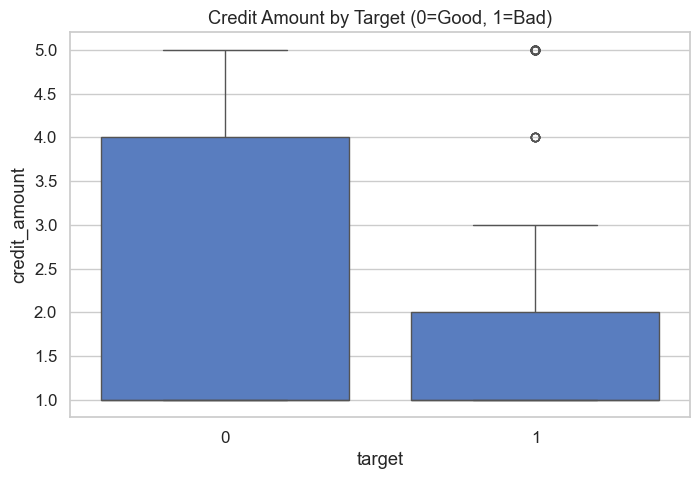

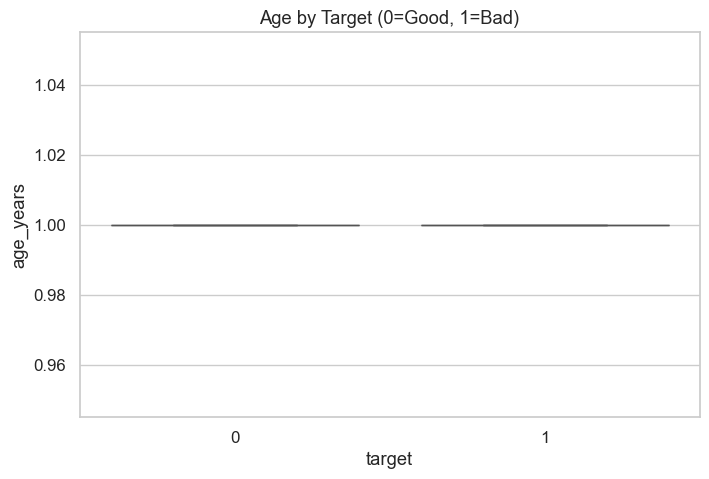

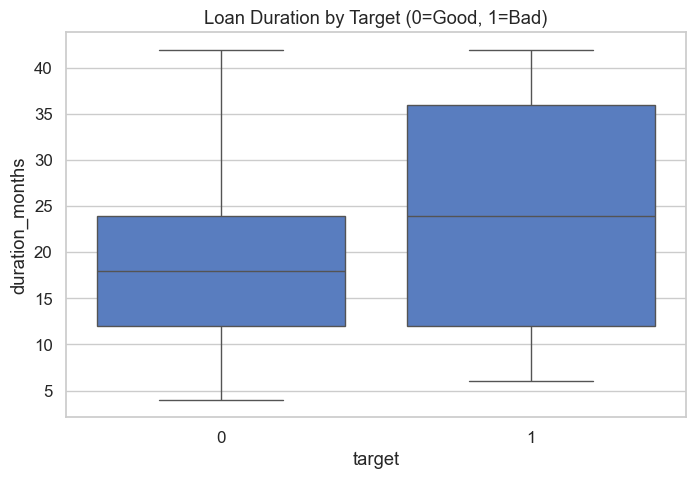

In [25]:
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# -------------------------------
# 1. Distribution plots by target
# -------------------------------
plt.figure(figsize=(8,5))
sns.boxplot(x="target", y="credit_amount", data=df)
plt.title("Credit Amount by Target (0=Good, 1=Bad)")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="target", y="age_years", data=df)
plt.title("Age by Target (0=Good, 1=Bad)")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x="target", y="duration_months", data=df)
plt.title("Loan Duration by Target (0=Good, 1=Bad)")
plt.show()

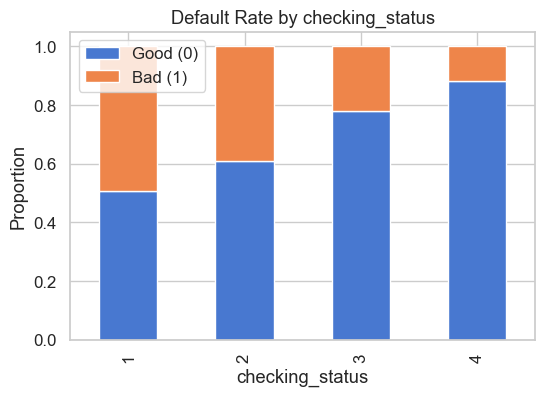

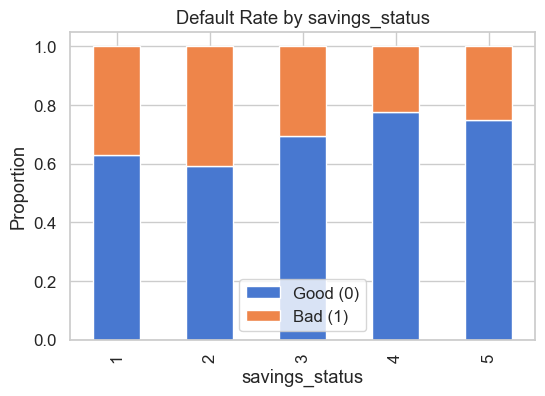

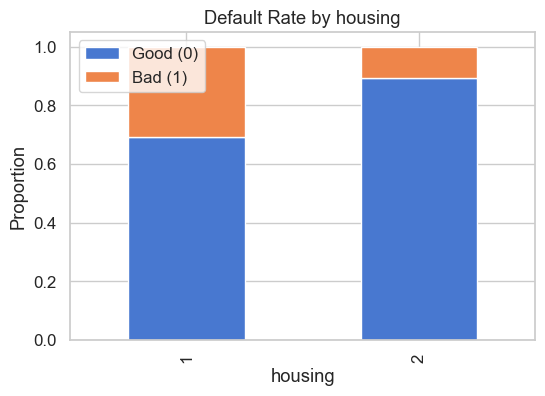

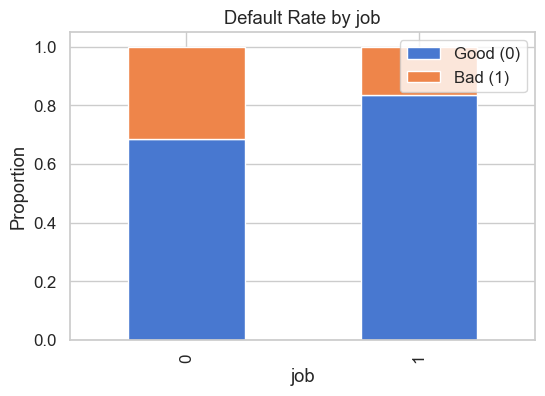

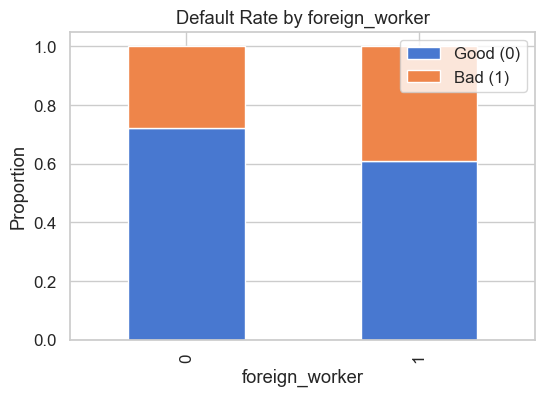

In [26]:
# -------------------------------
# 2. Crosstab/stacked bar (categorical vs target)
# -------------------------------
cat_cols = ["checking_status", "savings_status", "housing", "job", "foreign_worker"]

for col in cat_cols:
    ct = pd.crosstab(df[col], df["target"], normalize="index")
    ct.plot(kind="bar", stacked=True, figsize=(6,4))
    plt.title(f"Default Rate by {col}")
    plt.ylabel("Proportion")
    plt.legend(["Good (0)", "Bad (1)"])
    plt.show()

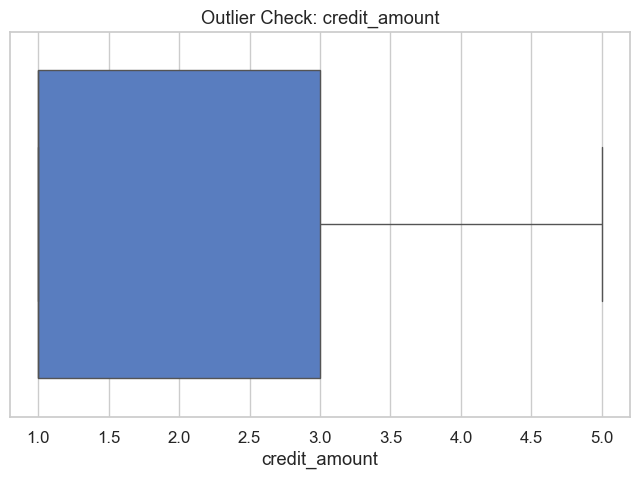

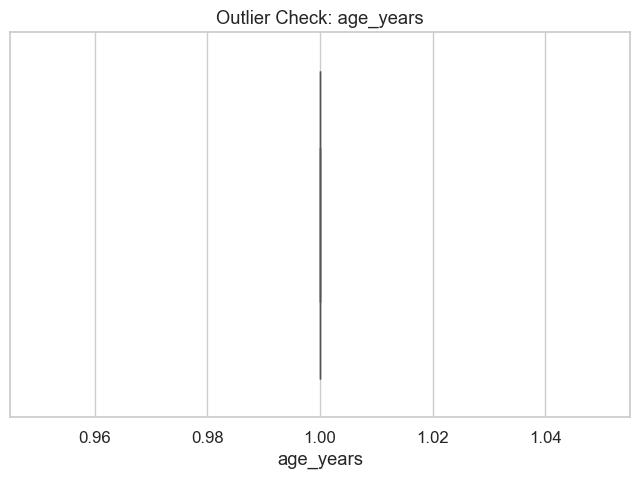

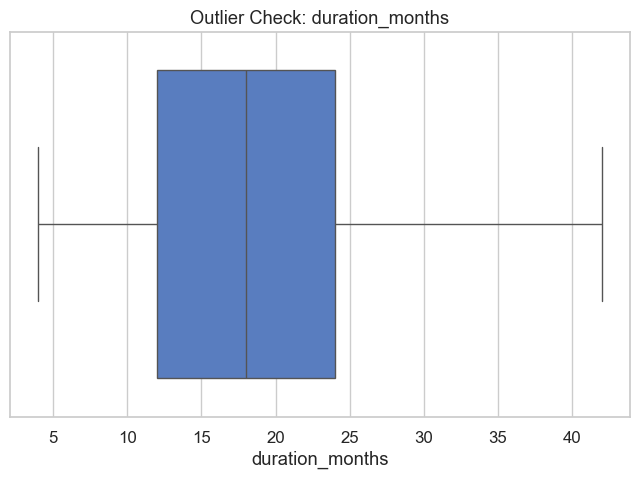

In [27]:
# -------------------------------
# 3. Outlier visualization
# -------------------------------
for col in ["credit_amount", "age_years", "duration_months"]:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=df[col])
    plt.title(f"Outlier Check: {col}")
    plt.show()

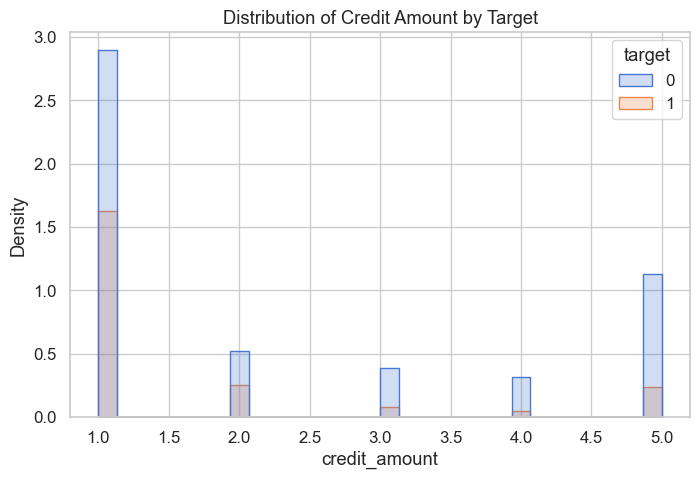

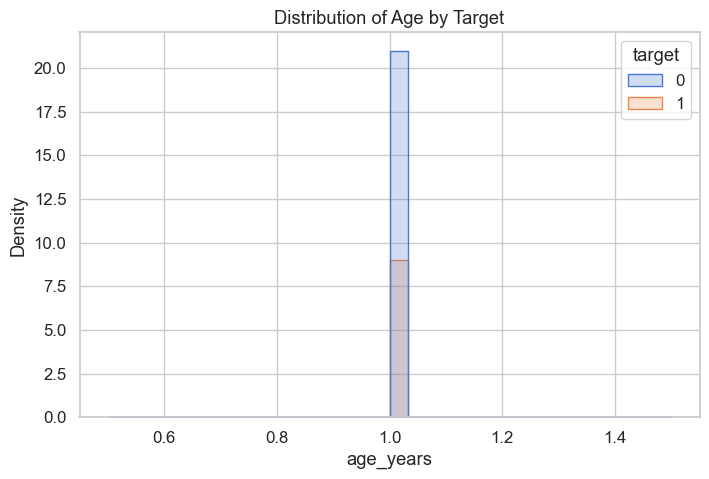

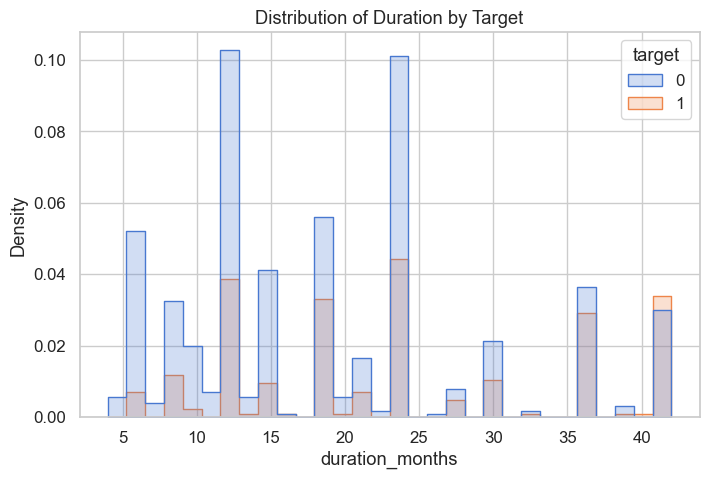

In [29]:

# -------------------------------
# 4. Class-conditional histograms
# -------------------------------
# Safer class-conditional histograms (without kde)
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="credit_amount", hue="target", bins=30, element="step", stat="density")
plt.title("Distribution of Credit Amount by Target")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(data=df, x="age_years", hue="target", bins=30, element="step", stat="density")
plt.title("Distribution of Age by Target")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(data=df, x="duration_months", hue="target", bins=30, element="step", stat="density")
plt.title("Distribution of Duration by Target")
plt.show()


In [32]:
from scipy.stats import pointbiserialr

# 0) Quick schema check
print("Columns on df:", list(df.columns))

# 1) Ensure age_years column exists; if your file used 'age' instead, rename it
if "age_years" not in df.columns and "age" in df.columns:
    df = df.rename(columns={"age": "age_years"})
    print("Renamed 'age' -> 'age_years'")

# 2) Force numeric dtype (in case it's object/string)
if "age_years" in df.columns:
    df["age_years"] = pd.to_numeric(df["age_years"], errors="coerce")
    print("age_years dtype:", df["age_years"].dtype)
else:
    raise KeyError("No column named 'age_years' or 'age' found. Check your earlier renaming step.")

# 3) Inspect distribution
print("\nage_years.describe():\n", df["age_years"].describe())
print("Unique ages:", df["age_years"].nunique())

# 4) If constant or many NaNs, restore age from the RAW file (column index per numeric schema)
#    Numeric UCI file has 25 columns; age is the 13th (1-based) -> index 12 (0-based).
needs_restore = (df["age_years"].nunique() <= 1) or df["age_years"].isna().all()

if needs_restore:
    print("\n[Fix] age_years looks constant or invalid. Reloading from raw file...")
    df_raw = pd.read_csv("data/german.data-numeric", sep=r"\s+", header=None, engine="python")
    if df_raw.shape[1] < 13:
        raise ValueError(f"Raw file has unexpected shape: {df_raw.shape}")
    age_from_raw = pd.to_numeric(df_raw.iloc[:, 12], errors="coerce")  # 13th col (0-based 12)
    # Sanity check
    print("Raw age nunique:", age_from_raw.nunique(), "min:", age_from_raw.min(), "max:", age_from_raw.max())
    df["age_years"] = age_from_raw.values
    print("Restored 'age_years' from raw file.")

# 5) Recompute point-biserial correlations safely (skip constant cols)
num_cols = ["duration_months", "credit_amount", "age_years"]
correlations = {}
for col in num_cols:
    x = df[col]
    if x.nunique() > 1 and not x.isna().all():
        corr, pval = pointbiserialr(x, df["target"])
        correlations[col] = {"Correlation": round(float(corr), 3), "p-value": round(float(pval), 5)}
    else:
        correlations[col] = {"Correlation": "NA (constant/invalid)", "p-value": "NA"}

print("\nPoint-Biserial Correlation of numeric features with Target:")
for col, vals in correlations.items():
    print(f"{col}: Corr={vals['Correlation']}, p={vals['p-value']}")

Columns on df: ['checking_status', 'duration_months', 'credit_history', 'purpose', 'credit_amount', 'savings_status', 'employment_since', 'installment_rate_pct', 'personal_status_sex', 'other_debtors', 'residence_since', 'property_magnitude', 'age_years', 'other_installment_plans', 'housing', 'number_existing_credits', 'job', 'people_liable_maintenance', 'telephone', 'foreign_worker', 'extra_indicator_1', 'extra_indicator_2', 'extra_indicator_3', 'extra_indicator_4', 'target', 'credit_amount_log', 'duration_scaled', 'credit_amount_scaled', 'age_scaled']
age_years dtype: float64

age_years.describe():
 count    1000.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: age_years, dtype: float64
Unique ages: 1

[Fix] age_years looks constant or invalid. Reloading from raw file...
Raw age nunique: 2 min: 1 max: 2
Restored 'age_years' from raw file.

Point-Biserial Correlation of numeric features with Target:
duration_months

In [33]:
# 1) Load raw categorical dataset
df_raw = pd.read_csv("data/german.data", sep=r"\s+", header=None, engine="python")

# 2) Official column names (20 features + target)
cols = [
    "checking_status", "duration", "credit_history", "purpose", "credit_amount",
    "savings_status", "employment_since", "installment_rate_pct", "personal_status_sex",
    "other_debtors", "residence_since", "property_magnitude", "age",
    "other_installment_plans", "housing", "number_existing_credits", "job",
    "people_liable_maintenance", "telephone", "foreign_worker", "target"
]
df_raw.columns = cols

# 3) Target to binary: 1=good -> 0, 2=bad -> 1  (bad = default)
df_raw["target"] = df_raw["target"].map({1: 0, 2: 1}).astype(int)

# 4) Optional: map A-codes to readable labels (you can skip this; one-hot on codes also works)
map_dicts = {
    "checking_status": {"A11":"<0", "A12":"0<= <200", "A13":">=200", "A14":"no_checking"},
    "credit_history": {"A30":"no_credits/all_paid", "A31":"all_paid",
                       "A32":"existing_paid", "A33":"delayed",
                       "A34":"critical/other"},
    "purpose": {"A40":"car_new","A41":"car_used","A42":"furniture","A43":"radio_tv","A44":"appliances",
                "A45":"repairs","A46":"education","A47":"vacation","A48":"retraining",
                "A49":"business","A410":"other"},
    "savings_status": {"A61":"<100","A62":"100-500","A63":"500-1000","A64":">=1000","A65":"unknown"},
    "employment_since": {"A71":"unemployed","A72":"<1","A73":"1-4","A74":"4-7","A75":">=7"},
    "personal_status_sex": {"A91":"male_single","A92":"male_div_sep","A93":"male_mar_wid","A94":"female_any"},
    "other_debtors": {"A101":"none","A102":"co-applicant","A103":"guarantor"},
    "property_magnitude": {"A121":"real_estate","A122":"life_insurance","A123":"car_other","A124":"none/unknown"},
    "other_installment_plans": {"A141":"bank","A142":"stores","A143":"none"},
    "housing": {"A151":"rent","A152":"own","A153":"free"},
    "job": {"A171":"unemployed_unskilled_nonres","A172":"unskilled_resident",
            "A173":"skilled","A174":"management/self_emp/high_qual"},
    "telephone": {"A191":"none","A192":"yes_registered"},
    "foreign_worker": {"A201":"yes","A202":"no"},
}

for c, m in map_dicts.items():
    if c in df_raw.columns:
        df_raw[c] = df_raw[c].map(m).astype("category")

# 5) Ensure 'age' is numeric years
df_raw["age"] = pd.to_numeric(df_raw["age"], errors="coerce")

print("Shape:", df_raw.shape)
print(df_raw[["age","duration","credit_amount","target"]].describe())
print("\nAge unique sample:", sorted(df_raw["age"].dropna().unique())[:10], " ...")
print("\nCategorical example values:")
print(df_raw[["checking_status","purpose","savings_status"]].head())

Shape: (1000, 21)
               age     duration  credit_amount       target
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000    20.903000    3271.258000     0.300000
std      11.375469    12.058814    2822.736876     0.458487
min      19.000000     4.000000     250.000000     0.000000
25%      27.000000    12.000000    1365.500000     0.000000
50%      33.000000    18.000000    2319.500000     0.000000
75%      42.000000    24.000000    3972.250000     1.000000
max      75.000000    72.000000   18424.000000     1.000000

Age unique sample: [np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28)]  ...

Categorical example values:
  checking_status    purpose savings_status
0              <0   radio_tv        unknown
1        0<= <200   radio_tv           <100
2     no_checking  education           <100
3              <0  furniture           <100
4              <0    car_ne

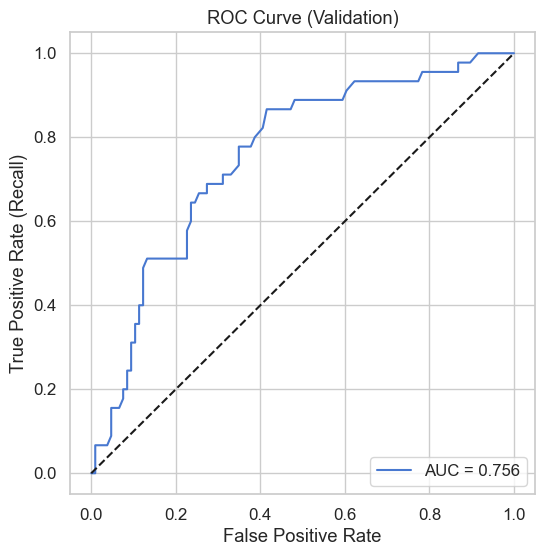

In [35]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
# -------------------
# 1. ROC Curve (Validation)
# -------------------
proba_val = best_model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, proba_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Validation)")
plt.legend(loc="lower right")
plt.show()

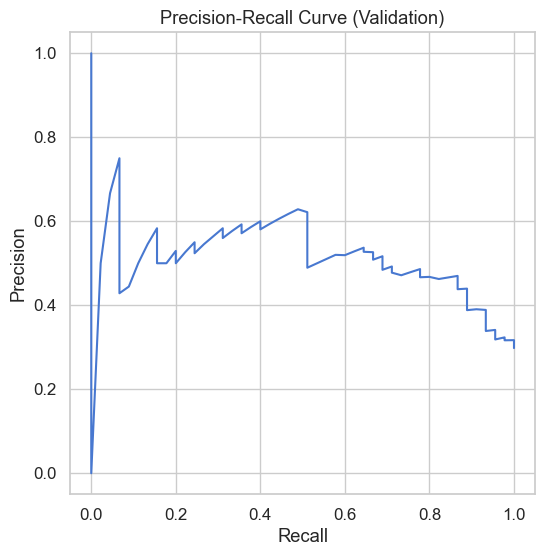

In [36]:
# -------------------
# 2. Precision-Recall Curve (Validation)
# -------------------
prec, rec, pr_thresh = precision_recall_curve(y_val, proba_val)
plt.figure(figsize=(6,6))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.show()


In [37]:
# -------------------
# 3. Threshold Sweep
# -------------------
def threshold_analysis(y_true, proba, thresholds=[0.3, 0.35, 0.4, 0.5]):
    from sklearn.metrics import precision_score, recall_score, f1_score
    results = []
    for t in thresholds:
        preds = (proba >= t).astype(int)
        results.append({
            "Threshold": t,
            "Precision": round(precision_score(y_true, preds), 3),
            "Recall": round(recall_score(y_true, preds), 3),
            "F1": round(f1_score(y_true, preds), 3)
        })
    return pd.DataFrame(results)

df_thresh = threshold_analysis(y_val, proba_val, thresholds=np.arange(0.2,0.61,0.05))
print("\nThreshold tuning on Validation set:")
print(df_thresh)


Threshold tuning on Validation set:
   Threshold  Precision  Recall     F1
0       0.20      0.378   0.933  0.538
1       0.25      0.435   0.889  0.584
2       0.30      0.468   0.800  0.590
3       0.35      0.478   0.711  0.571
4       0.40      0.528   0.622  0.571
5       0.45      0.575   0.511  0.541
6       0.50      0.581   0.400  0.474
7       0.55      0.577   0.333  0.423
8       0.60      0.538   0.156  0.241



Profit analysis (Validation):
   Threshold  TP  FP  FN   TN   Avg Profit
0       0.20  42  69   3   37  -533.112583
1       0.25  40  52   5   54  -496.688742
2       0.30  36  41   9   65  -652.317881
3       0.35  32  35  13   71  -857.615894
4       0.40  28  25  17   81 -1023.178808
5       0.45  23  17  22   89 -1274.834437
6       0.50  18  13  27   93 -1566.225166
7       0.55  15  11  30   95 -1745.033113
8       0.60   7   6  38  100 -2225.165563


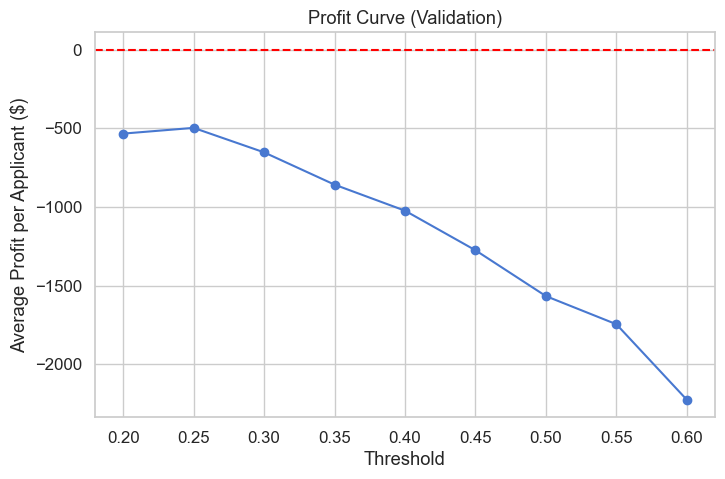

In [38]:
# Business assumptions (you can adjust these 💰)
COST_FN = -10000   # Approve a default
COST_FP = -1000    # Reject a good borrower
GAIN_TP = 0        # Correctly flag a default (loss avoided, no profit)
GAIN_TN = 500      # Approve a good borrower (interest margin, fees)

def profit_curve(y_true, proba, thresholds=np.arange(0.2,0.61,0.05)):
    results = []
    for t in thresholds:
        preds = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
        profit = (tp * GAIN_TP) + (tn * GAIN_TN) + (fp * COST_FP) + (fn * COST_FN)
        avg_profit = profit / len(y_true)
        results.append({"Threshold": t, "TP":tp,"FP":fp,"FN":fn,"TN":tn,"Avg Profit": avg_profit})
    return pd.DataFrame(results)

# Run on Validation set
df_profit = profit_curve(y_val, proba_val, thresholds=np.arange(0.2,0.61,0.05))
print("\nProfit analysis (Validation):")
print(df_profit)

# Plot
plt.figure(figsize=(8,5))
plt.plot(df_profit["Threshold"], df_profit["Avg Profit"], marker="o")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Threshold")
plt.ylabel("Average Profit per Applicant ($)")
plt.title("Profit Curve (Validation)")
plt.show()

In [39]:
# -----------------------------
# 0) Choose the model to deploy
# -----------------------------
try:
    chosen_model = best_model   # or set to lr_model / rf_model / lr_sm_model / rf_sm_model
except NameError:
    chosen_model = lr_model

In [40]:
# -----------------------------
# 1) Business costs / gains ($)
# -----------------------------
COST_FN = -10000   # Approved a default (bad)
COST_FP = -1000    # Rejected a good borrower (opp. cost)
GAIN_TP = 0        # Caught a default (loss avoided)
GAIN_TN = 500      # Approved a good borrower (margin)

def profit_table(y_true, proba, thresholds):
    rows = []
    for t in thresholds:
        pred = (proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        total_profit = tp*GAIN_TP + tn*GAIN_TN + fp*COST_FP + fn*COST_FN
        rows.append({
            "Threshold": t,
            "TP": tp, "FP": fp, "FN": fn, "TN": tn,
            "Avg Profit": total_profit / len(y_true),
            "Precision": precision_score(y_true, pred, zero_division=0),
            "Recall": recall_score(y_true, pred, zero_division=0),
            "F1": f1_score(y_true, pred, zero_division=0),
        })
    return pd.DataFrame(rows)


In [42]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# -----------------------------
# 3) Lock threshold, evaluate on TEST
# -----------------------------
proba_test = chosen_model.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= best_thresh).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
test_profit = tp*GAIN_TP + tn*GAIN_TN + fp*COST_FP + fn*COST_FN
avg_profit_test = test_profit / len(y_test)

print("\n=== Test Evaluation @ chosen threshold ===")
print(f"Threshold: {best_thresh:.2f}")
print("Confusion matrix [TN FP; FN TP]:")
print(np.array([[tn, fp],[fn, tp]]))
print("Precision:", round(precision_score(y_test, pred_test, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, pred_test, zero_division=0), 4))
print("F1       :", round(f1_score(y_test, pred_test, zero_division=0), 4))
print("Test AUC (prob only):", round(roc_auc_score(y_test, proba_test), 4))
print(f"Average Profit per applicant (TEST): ${avg_profit_test:,.2f}")

# -----------------------------
# 2) Build profit curve on VAL
# -----------------------------
proba_val = chosen_model.predict_proba(X_val)[:, 1]
thresholds = np.round(np.arange(0.20, 0.61, 0.01), 2)
df_profit_val = profit_table(y_val, proba_val, thresholds)

# Pick the best threshold by Avg Profit
best_row = df_profit_val.loc[df_profit_val["Avg Profit"].idxmax()]
best_thresh = float(best_row["Threshold"])

print("=== Validation Profit Analysis ===")
print(df_profit_val.sort_values("Avg Profit", ascending=False).head(10).to_string(index=False))
print(f"\n>>> Selected Threshold (max Avg Profit): {best_thresh:.2f}")

# Optional: see AUC too
auc_val = roc_auc_score(y_val, proba_val)
print("Validation AUC (for reference):", round(auc_val, 4))


=== Validation Profit Analysis ===
 Threshold  TP  FP  FN  TN  Avg Profit  Precision   Recall       F1
      0.28  39  45   6  61 -493.377483   0.464286 0.866667 0.604651
      0.25  40  52   5  54 -496.688742   0.434783 0.888889 0.583942
      0.27  39  46   6  60 -503.311258   0.458824 0.866667 0.600000
      0.24  40  55   5  51 -526.490066   0.421053 0.888889 0.571429
      0.20  42  69   3  37 -533.112583   0.378378 0.933333 0.538462
      0.26  39  50   6  56 -543.046358   0.438202 0.866667 0.582090
      0.21  41  64   4  42 -549.668874   0.390476 0.911111 0.546667
      0.23  40  60   5  46 -576.158940   0.400000 0.888889 0.551724
      0.22  40  63   5  43 -605.960265   0.388350 0.888889 0.540541
      0.29  37  43   8  63 -605.960265   0.462500 0.822222 0.592000

>>> Selected Threshold (max Avg Profit): 0.28
Validation AUC (for reference): 0.7565


In [43]:
# -----------------------------
# 3) Lock threshold, evaluate on TEST
# -----------------------------
proba_test = chosen_model.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= best_thresh).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()
test_profit = tp*GAIN_TP + tn*GAIN_TN + fp*COST_FP + fn*COST_FN
avg_profit_test = test_profit / len(y_test)

print("\n=== Test Evaluation @ chosen threshold ===")
print(f"Threshold: {best_thresh:.2f}")
print("Confusion matrix [TN FP; FN TP]:")
print(np.array([[tn, fp],[fn, tp]]))
print("Precision:", round(precision_score(y_test, pred_test, zero_division=0), 4))
print("Recall   :", round(recall_score(y_test, pred_test, zero_division=0), 4))
print("F1       :", round(f1_score(y_test, pred_test, zero_division=0), 4))
print("Test AUC (prob only):", round(roc_auc_score(y_test, proba_test), 4))
print(f"Average Profit per applicant (TEST): ${avg_profit_test:,.2f}")



=== Test Evaluation @ chosen threshold ===
Threshold: 0.28
Confusion matrix [TN FP; FN TP]:
[[50 55]
 [ 9 36]]
Precision: 0.3956
Recall   : 0.8
F1       : 0.5294
Test AUC (prob only): 0.7148
Average Profit per applicant (TEST): $-800.00


In [44]:
# -----------------------------
# 4) (Optional) Sensitivity around best threshold
# -----------------------------
pad = 0.05
grid = np.round(np.arange(max(0.01, best_thresh - pad), min(0.99, best_thresh + pad)+1e-9, 0.01), 2)
df_sens = profit_table(y_test, proba_test, grid).sort_values("Threshold")
print("\nThreshold sensitivity (Test):")
print(df_sens.to_string(index=False))


Threshold sensitivity (Test):
 Threshold  TP  FP  FN  TN   Avg Profit  Precision   Recall       F1
      0.23  41  60   4  45  -516.666667   0.405941 0.911111 0.561644
      0.24  39  58   6  47  -630.000000   0.402062 0.866667 0.549296
      0.25  38  58   7  47  -696.666667   0.395833 0.844444 0.539007
      0.26  37  58   8  47  -763.333333   0.389474 0.822222 0.528571
      0.27  36  56   9  49  -810.000000   0.391304 0.800000 0.525547
      0.28  36  55   9  50  -800.000000   0.395604 0.800000 0.529412
      0.29  36  52   9  53  -770.000000   0.409091 0.800000 0.541353
      0.30  35  52  10  53  -836.666667   0.402299 0.777778 0.530303
      0.31  34  50  11  55  -883.333333   0.404762 0.755556 0.527132
      0.32  33  50  12  55  -950.000000   0.397590 0.733333 0.515625
      0.33  30  49  15  56 -1140.000000   0.379747 0.666667 0.483871
